In [1]:
import os
import numpy as np
import pandas as pd
import music21 as m21
import mido
from typing import List
from itertools import product
from collections import defaultdict
from sklearn.externals import joblib
from scipy.sparse import dok_matrix, vstack
from easy_ml.tools.util import download_from_gcs

In [9]:
from scipy import sparse

In [2]:
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from matplotlib import pyplot as plt

In [4]:
DATA_DIR = '/home/jovyan/persistent_data/data/classical-corpus/'

In [4]:
download_from_gcs(bucket_name='midi-files',
                  prefix='collections/classical-collection/k_collection/',
                  local_fs_loc=DATA_DIR)

In [5]:
midi_files = os.listdir(DATA_DIR)

## Note Encoding Schemes
* m-Bar Encodings: Similar to a term-document frequency matrix. Encode a multinomial distribution of notes over a sequence of m measures
    * Parts together in their
    * Pitches encoded as their numerical value, rests encoded as 0
    * Pitches encoded as their numerical value, no rests
* m-bar time series: Each part is an m-bar time series over 127 notes
    * Pitches encoded as their numerical value, rests encoded as 0 (only sensible way in this scenario)
* n-Note Encodings: Similar to n-grams; sequences of m measures will be encoded into $127^n$ features
    * Pitches encoded as their numerical value, rests encoded as 0
    * Pitches encoded as their numerical value, no rests
* n-Note Pitch-Difference Encodings: Similar to above, but instead of mapping each feature distinct pitch as a feature, the difference between subsequent pitches will be analyzed to try to capture melodic patterns
    * Pitches encoded as their numerical value, rests encoded as 0? (probably not sensible in this scenario)
    * Pitches encoded as their numerical value, no rests
    * Do we add durations (like in A Comparison of Statistical Approaches to Symbolic Genre Recognition)

**NOTE** Generate the full feature set by iterating through the entire scale of notes

### n-Note Encodings

In [334]:
# TODO: coansistency in variable namings (e.g. path_ vs path)
# TODO: docstrings
# TODO: save additional metadata?

In [10]:
def window_gen(sequence, n):
    windowed_iterator = []
    low = 0
    high = n
    for note in sequence:
        window = sequence[low:high]
        if len(window) < n:
            break
        low += 1
        high += 1
        yield tuple(window)

In [11]:
class MidiFeatureCorpus(object):
    def __init__(self, path: str, note_window_size: int = 2):
        self.path = path
        self.note_window_size_ = note_window_size
        self.files_ = self._depth_first_midi_search(self.path)
        self.note_sequence_set = self.initialize_note_sequence_set(note_window_size)
        self.sparse_matrix = dok_matrix((len(self.files_),
                                         len(self.note_sequence_set)),
                                        dtype=np.float32)
    
    def _depth_first_midi_search(self, path: str) -> List[str]:
        files_out = []
        paths = os.listdir(path)
        for p in paths:
            full_subpath = path + "/" + p
            try:
                dir_contents = os.listdir(full_subpath)
                dfs_results = self._depth_first_midi_search(full_subpath)
                for file in dfs_results:
                    files_out.append(file)
            except NotADirectoryError:
                if full_subpath.endswith(".mid"):
                    files_out.append(full_subpath)
        return files_out
    
    @staticmethod
    def initialize_note_sequence_set(window_size: int):
        notes = [str(i) for i in range(128)]
        notes_copies = [notes for i in range(window_size)]
        note_sequences = []
        for combo in product(*notes_copies):
            note_sequences.append(combo[0] + "|" + combo[1])
        return note_sequences
    
    @staticmethod
    def get_n_note_sequence(midi: mido.MidiFile,
                            note_window_size: int = 2):
        notes = [str(m.note) for m in midi if m.type == "note_on"]
        n_note_sequences = []
        for note_seq in window_gen(notes, note_window_size):
            n_note_sequences.append("|".join([note for note in note_seq]))
        return n_note_sequences
    
    @staticmethod
    def sequence_encoder(seq: List[str]):
        d = defaultdict(float)
        for entry in seq:
            d[entry] += 1.
        return d
    
    def _parse_file_as_sequence(self, file_name):
        parsed_file = mido.MidiFile(file_name)
        return self.get_n_note_sequence(parsed_file, self.note_window_size_)
        
        
    def parse_corpus(self):
        for i, file in enumerate(self.files_):
            try:
                sequence = self._parse_file_as_sequence(file)
                encoded_sequence = self.sequence_encoder(sequence)
                for (seq, count) in encoded_sequence.items():
                    j = self.note_sequence_set.index(seq)
                    self.sparse_matrix[i, j] = count
            except:
#             except (OSError, KeyError, EOFError, ValueError) as e:
                continue

In [12]:
class LabeledCorpusSet(object):
    def __init__(self, path: str, note_window_size: int = 2):
        self.path_ = path
        self.note_window_size_ = note_window_size
        self.corpus_name_list_ = os.listdir(self.path_)
        self.corpus_labels = []
        self.corpus_list_ = []
        matrix_shape = (0, len(MidiFeatureCorpus.initialize_note_sequence_set(note_window_size)))
        self.sparse_matrix = dok_matrix(matrix_shape)
        self.parsed_ = False
        
    def parse_corpus_set(self):
        """
        Iterates through the files in the corpus. Will ignore directory structure within
        a corpus (e.g. if cantatas and sonatas are in different files)
        """
        matrix_set = []
        for corpus_name in self.corpus_name_list_:
            file_path = self.path_ + corpus_name
            print("reading from {}".format(file_path))
            corpus = MidiFeatureCorpus(file_path, self.note_window_size_)
            corpus.parse_corpus()
            self.corpus_list_.append(corpus)
            for label in range(corpus.sparse_matrix.shape[0]):
                self.corpus_labels.append(corpus_name)
            matrix_set.append(corpus.sparse_matrix)
        self.sparse_matrix = vstack(matrix_set)
        self.parsed_ = True

In [14]:
labeled_corpus = LabeledCorpusSet(DATA_DIR)

In [ ]:
labeled_corpus.parse_corpus_set()

reading from /home/jovyan/persistent_data/data/classical-corpus/gabrieli's
reading from /home/jovyan/persistent_data/data/classical-corpus/telemann
reading from /home/jovyan/persistent_data/data/classical-corpus/medtner
reading from /home/jovyan/persistent_data/data/classical-corpus/haydn


In [22]:
joblib.dump(labeled_corpus, "/home/jovyan/persistent_data/data/dumps/labeled_corpus.pkl",
           compress=0)

['/home/jovyan/persistent_data/data/dumps/labeled_corpus.pkl',
 '/home/jovyan/persistent_data/data/dumps/labeled_corpus.pkl_01.npy',
 '/home/jovyan/persistent_data/data/dumps/labeled_corpus.pkl_02.npy',
 '/home/jovyan/persistent_data/data/dumps/labeled_corpus.pkl_03.npy']

In [24]:
joblib.dump(labeled_corpus.sparse_matrixrse_matrix, "/home/jovyan/persistent_data/data/dumps/labeled_corpus_matrix.pkl",
           compress=0)

['/home/jovyan/persistent_data/data/dumps/labeled_corpus_matrix.pkl',
 '/home/jovyan/persistent_data/data/dumps/labeled_corpus_matrix.pkl_01.npy',
 '/home/jovyan/persistent_data/data/dumps/labeled_corpus_matrix.pkl_02.npy',
 '/home/jovyan/persistent_data/data/dumps/labeled_corpus_matrix.pkl_03.npy']

In [23]:
joblib.dump(labeled_corpus.corpus_labels, "/home/jovyan/persistent_data/data/dumps/labeled_corpus_labels.pkl",
           compress=0)

['/home/jovyan/persistent_data/data/dumps/labeled_corpus_labels.pkl']

In [25]:
corpus_matrix = labeled_corpus.sparse_matrix.todense()

In [26]:
print(1)

1


In [27]:
labels = labeled_corpus.corpus_labels
bach_labels = [k for k in range(len(labels)) if labels[k] == "bach-js"]
beethoven_labels = [k for k in range(len(labels)) if labels[k] == "beethoven"]

In [28]:
X = corpus_matrix[bach_labels + beethoven_labels]
y = np.array([1 for i in range(len(bach_labels))] + [0 for i in range(len(beethoven_labels))])

In [29]:
y.shape

(2966,)

In [30]:
y = y.reshape(y.shape[0], 1, )

In [31]:
new_X = X[:,(X.sum(axis=0) != 0).A.ravel()].A

# Modeling

In [32]:
class PenalizedLogisticRegression(object):
    """
    Logistic Regression with an L2 penalty
    """

    def __init__(self, X: np.array,
                 y: np.array,
                 l2_penalty: float = 0.,
                 num_iter: int = 10):
        """
        :param X: (N * M)-dimensional array containing the input data in matrix form
        :param y: (N * 1)-dimensional array containing the binary target variable, encoded as 0 and 1
        :param l2_penalty: The regularization parameter that enforces sparseness in the coefficients of our model
        :param num_iter: The number of iterations to use in running the Newton-Raphson algorithm
        """
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        self.X = X
        self.y = y
        self.lmbda_ = l2_penalty
        self.beta_ = np.zeros((1, X.shape[1]))  # np.random.uniform(-1, 1, size=(1, X.shape[1]))
        self.num_iter_ = num_iter
        self.log_likelihood_ = []

    def _log_likelihood(self) -> float:
        """
        Return the log-likelihood of the model given the data (i.e. P(D|M))
        :return:
        """
        theta_dot_x = self.beta_.dot(self.X.T)
        log_prob_data_given_theta = self.y * theta_dot_x - np.log(1 + np.exp(theta_dot_x))
        return np.sum(log_prob_data_given_theta)

    def predict_probabilities(self, new_X: np.array = None) -> np.array:
        """
        Return the vector of probability predictions
        :param new_X:
        :return:
        """
        if new_X is None:
            exp_log_odds = np.exp(np.dot(self.beta_, self.X.T)).T
        else:
            new_X = np.hstack([new_X, np.ones((new_X.shape[0], 1))])
            exp_log_odds = np.exp(np.dot(self.beta_, new_X.T)).T
        return (1. / (1. + exp_log_odds)).ravel()

    def _score_function(self, probabilities) -> np.array:
        """
        The gradient of the log-likelihood function
        :param probabilities: (N * 1)-dimensional array of inferred probabilities
        :return: (1 * M+1)-dimensional array
        """
        return np.dot(self.X.T, (self.y - probabilities)) + self.lmbda_ * self.beta_

    def _hessian(self, probabilities: np.array) -> np.array:
        """
        The second derivative of the log-likelihood function
        :param probabilities: (N * 1)-dimensional array of inferred probabilities
        :return: (M+1 * M+1)-dimensional array
        """
        W = np.eye(self.X.shape[0])
        for i in range(W.shape[0]):
            W[i, i] = probabilities[i] * (1 - probabilities[i])
        return self.X.T.dot(W).dot(self.X) + self.lmbda_ * np.eye(self.X.shape[1])

    def _newton_step(self) -> np.array:
        """
        Take one Newton-Raphson step. That is, move to where the tangent line of the
        first derivative of the log-likelihood function (score function) is equal to 0.
        :return: (M+1 * 1)-dimensional array containing the new parameters of the model (self.beta_)
        """
        probs = self.predict_probabilities()
        score = self._score_function(probs)
        hess = self._hessian(probs)
        step = np.linalg.inv(hess).dot(score.T).ravel()
        return (self.beta_ - step).reshape(self.beta_.shape)

    def _newton_raphson(self):
        """
        Run self.num_iter_ iterations of the Newton-Raphson algorithm to fit a logistic regression model
        :return:
        """
        for i in range(self.num_iter_):
            print("Running iteration {num} of Newton-Raphson algorithm".format(num=str(i)))
            self.log_likelihood_.append(self._log_likelihood())
            self.beta_ = self._newton_step()
        print("Model-fitting complete")

    def fit(self):
        """
        Fit a penalized logistic regression model
        :return:
        """
        self._newton_raphson()

In [33]:
from sklearn.cross_validation import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.25)

In [35]:
l = PenalizedLogisticRegression(X=X_train, y=y_train, l2_penalty=10, num_iter=5)

In [38]:
new_X.shape

(2966, 7284)

In [36]:
l.fit()

Running iteration 0 of Newton-Raphson algorithm


ValueError: operands could not be broadcast together with shapes (7285,2224) (1,7285) 

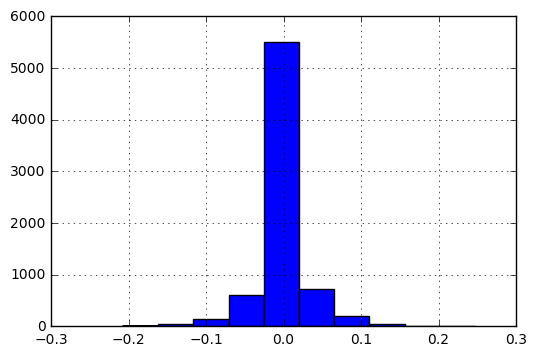

In [231]:
pd.Series(l.beta_.ravel()).hist()

(array([  492.,    40.,    18.,    27.,    13.,   119.,     6.,     9.,
           76.,  2166.]),
 array([  1.56499613e-18,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

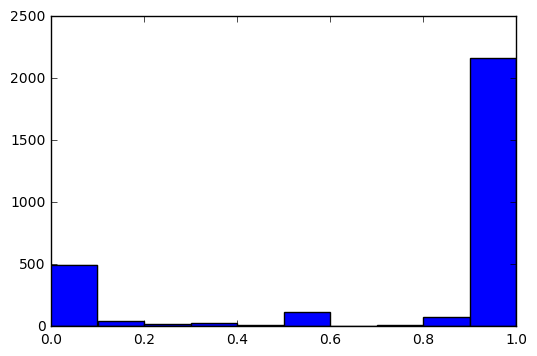

In [221]:
plt.hist(l.predict_probabilities())

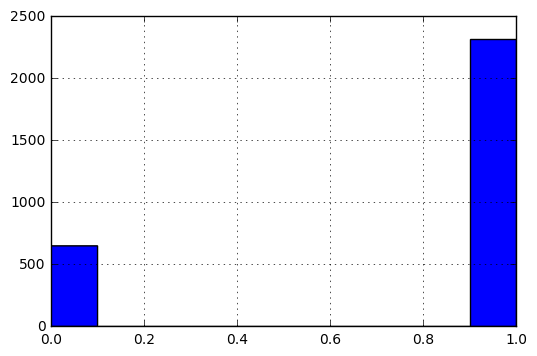

In [224]:
pd.Series(y).hist()

In [225]:
from sklearn.metrics import roc_auc_score

In [235]:
X_train.shape

(2224, 7284)

In [241]:
roc_auc_score(y_test, l.predict_probabilities(X_test))

0.83856428267347805